In [1]:
from WPI_SCA_LIBRARY.CWScope import *
from WPI_SCA_LIBRARY.LeakageModels import *
from WPI_SCA_LIBRARY.Metrics import *
firmware_path = "C:\\Users\\samka\\PycharmProjects\\MQP\\SCLA_API_MQP\\WPI_SCA_LIBRARY\\firmware\\simpleserial-aes-CWLITEARM-SS_2_1.hex"

## Create A File Using The Custom File Framework
We can create the parent directory and create the basic structure by calling the constructor for the `FileParent` class by simply specifying the file name and path.

In [2]:
# Let's create a file called NEHWS Demo and save it in the same directory that we currently in!
file = FileParent(name="NEHWS_Demo", path="C:\\Users\\samka\\PycharmProjects\\MQP\\SCLA_API_MQP\\Demos", existing=False)

## Collect some data from the ChipWhisperer-Lite Using the Oscilloscope Interface
We can collect some traces from a ChipWhisperer target board running AES128. This uses the most simple capture procedure supported leaving most settings to their default values. 

In [3]:
# We will load the target board with a simple AES implementation and collect 1000 traces each with 3000 samples. We will use a built-in key, text pair generator however you can specify custom values as an array if you want.
scope = CWScope(firmware_path, gain=25, num_samples=3000, offset=0, target_type=cw.targets.SimpleSerial2, target_programmer=cw.programmers.STM32FProgrammer)
traces, keys, plaintexts, ciphertexts = scope.standard_capture_traces(num_traces=1000, fixed_key=True, fixed_pt=False)

(ChipWhisperer Other ERROR|File util.py:362) Setting unknown attribute offset in <class 'chipwhisperer.capture.scopes.OpenADC.OpenADC'>


Detected known STMF32: STM32F302xB(C)/303xB(C)
Extended erase (0x44), this can take ten seconds or more
Attempting to program 6519 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 6519 bytes


Capturing 1000 Traces: 100%|██████████| 1000/1000 [00:15<00:00, 62.51it/s]


## Create an experiment and populate it with a few datasets
We collected some power traces along with keys, plaintexts, and ciphertexts. Let's create and experiment and add these as datasets to our file!

In [4]:
# Create the experiment
experiment_1 = file.add_experiment(name="Experiment1")

# add the data to the experiment
traces_dataset = experiment_1.add_dataset(name="Traces Dataset", data_to_add=traces, datatype='float32')
key_dataset = experiment_1.add_dataset(name="Keys Dataset", data_to_add=keys, datatype='uint8')
plaintext_dataset = experiment_1.add_dataset(name="Plaintexts Dataset", data_to_add=plaintexts, datatype='uint8')
ciphertext_dataset = experiment_1.add_dataset(name="Ciphertexts Dataset", data_to_add=ciphertexts, datatype='uint8')

## Now lets access some of the data that added and run few metrics

Computing Signal-To-Noise Ratio: 100%|██████████| 250/250 [00:00<00:00, 14706.54it/s]


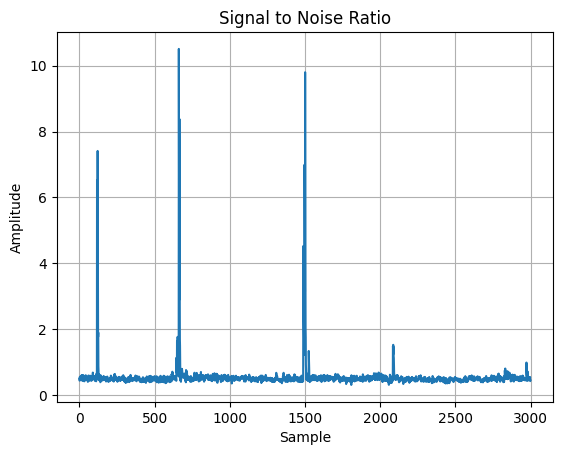

array([0.4924542 , 0.43509865, 0.43403903, ..., 0.5394625 , 0.42005044,
       0.44081736], dtype=float32)

In [5]:
# We will run SNR for this example.
traces = traces_dataset.read_all()
keys = key_dataset.read_all()
plaintexts = plaintext_dataset.read_all()


# organize labels using traces, keys and plaintexts
labels = Sbox[plaintexts ^ keys]
labels = labels[:, 1] 
labelsUnique = np.unique(labels)
# initialize the dictionary
sorted_labels = {}
for i in labelsUnique:
    sorted_labels[i] = []

# add traces to labels
for index, label in enumerate(labels):
    sorted_labels[label].append(np.array(traces[index]))

# run metric and visualize result. Save it in the visualization folder. 
signal_to_noise_ratio(sorted_labels, visualize=True, visualization_path=experiment_1.get_visualization_path() + "SNR_1")

## Let's collect some traces to run the t-test metric

In [6]:
# there is a built-in capture procedure for collecting the fixed and random sets
fixed_t, rand_t = scope.capture_traces_tvla(1000, ktp=cwtvla.ktp.FixedVRandomText())

Capturing Fixed and Random Trace Sets: 100%|██████████| 1000/1000 [00:31<00:00, 31.44it/s]


## We can use the same file as before but put these two trace sets into a new experiment

In [7]:
# create a new experiment
t_test_exp = file.add_experiment(name="T_Test_Experiment")

# add two datasets, one for the fixed traces and one for the random traces
fixed_dataset = t_test_exp.add_dataset(name="Fixed_dataset", data_to_add=fixed_t, datatype='float32')
rand_dataset = t_test_exp.add_dataset(name="rand_dataset", data_to_add=rand_t, datatype='float32')

## Metadata 
One of the cool features of our custom file framework is that we can create arbitrary metadata and associate it at the file, experiment, or dataset level.

In [8]:
# let's add a piece of metadata called "purpose" and give it a value of "run t-test metric on AES128" for the experiment
t_test_exp.update_metadata(key="purpose", value="run t-test metric on AES128")

# assume that we concerned with the temperature during each of the trace captures, we can add a piece of metadata to the datasets as wel
fixed_dataset.update_metadata(key="temp", value="30C")
rand_dataset.update_metadata(key="temp", value="25C")

## Let's now read from those datasets and run the t-test metric

Calculating T-Test: 100%|██████████| 1000/1000 [00:01<00:00, 838.85it/s]


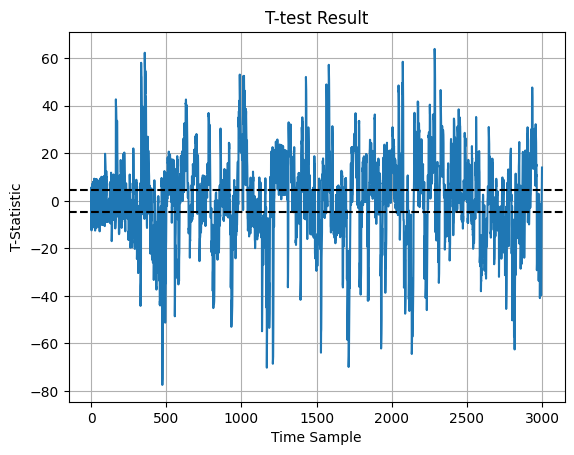

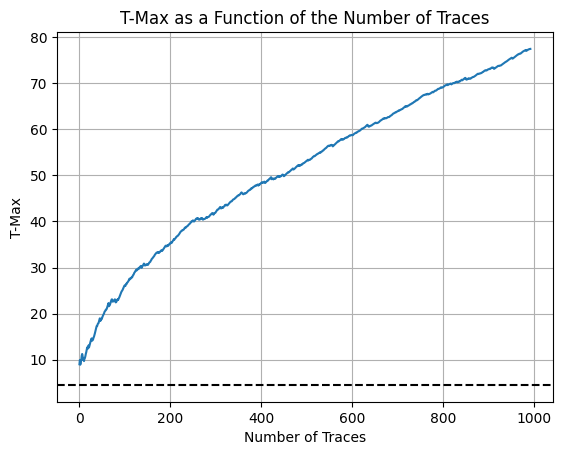

(array([5.4397510276980245, -9.89211533973498, -6.265124187677848, ...,
        2.7345966529528716, 6.5443575260823525, 13.999711903520875],
       dtype=object),
 [8.991223791184261,
  9.928141820099064,
  8.923724813371466,
  9.577210825168716,
  9.886521381628246,
  10.840713922186175,
  11.22446629168277,
  10.746781321790795,
  9.947383683753497,
  10.173693681583147,
  9.670564710826397,
  10.162499859756744,
  10.336357382543554,
  10.72083602841585,
  11.240015651851131,
  11.617679953533422,
  12.152764042644568,
  12.657198004517593,
  12.330268319748399,
  12.536225659908391,
  13.089811961575661,
  12.621612574063356,
  13.021342745240357,
  13.499425349270332,
  13.798284101118837,
  14.140297689487904,
  14.44710820603516,
  14.607886115028215,
  14.099023798371267,
  14.244469548027975,
  14.378588351245487,
  14.770260305305339,
  14.9761690987734,
  15.328374744427203,
  15.706279615340843,
  16.14708202941065,
  16.512860508620104,
  16.94231573476232,
  17.3036182539

In [9]:
# parse from datasets
fixed_traces = fixed_dataset.read_all()
rand_traces = rand_dataset.read_all()

# run metric and visualize
t_test_tvla(fixed_t, rand_t, visualize=True)

## Our example file is much larger now. Let's say we no longer wanted the Ciphertext dataset.

In [10]:
# we can delete the dataset like so... This will also remove it from the JSON!
experiment_1.delete_dataset("Ciphertexts Dataset")

Deleting dataset ciphertexts dataset
